In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.utils
import torchvision
import torchvision.io

import _frameload


transform_forward = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(64),
    torchvision.transforms.Normalize([0.5] * 3, [0.5] * 3),
])
transform_backward = torchvision.transforms.Compose([
    torchvision.transforms.Normalize([-1.] * 3, [2.] * 3),
    torchvision.transforms.ToPILImage(),
])


In [2]:
images_train, labels_train, images_test, labels_test = \
    _frameload.main('train/')


In [3]:
class Frames(torch.utils.data.Dataset):
    def __init__(self, train, train_vs_test_files=((0, 1), (6, 7)),
                 transform=transform_forward, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform

        # get random indices
        if train is True:
            shuffled = np.random.permutation(len(images_train))
            self.images = images_train[shuffled].float()
            self.labels = labels_train[shuffled].float()
        else:
            shuffled = np.random.permutation(len(images_test))
            self.images = images_test[shuffled].float()
            self.labels = labels_test[shuffled].float()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


In [4]:
dataset_train = Frames(
    train=True,
    transform=transform_forward
)
dataset_test = Frames(
    train=False,
    transform=transform_forward
)


img    25709	 shape torch.Size([3, 64, 64])   	 type anime
img    29354	 shape torch.Size([3, 64, 64])   	 type photo
img     6330	 shape torch.Size([3, 64, 64])   	 type anime
img    33375	 shape torch.Size([3, 64, 64])   	 type anime


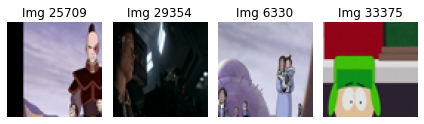

img    12745	 shape torch.Size([3, 64, 64])   	 type photo
img    16298	 shape torch.Size([3, 64, 64])   	 type photo
img     5404	 shape torch.Size([3, 64, 64])   	 type photo
img    15666	 shape torch.Size([3, 64, 64])   	 type anime


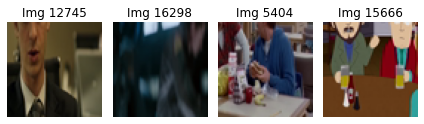

img    34248	 shape torch.Size([3, 64, 64])   	 type anime
img    19972	 shape torch.Size([3, 64, 64])   	 type anime
img     6246	 shape torch.Size([3, 64, 64])   	 type photo
img    45951	 shape torch.Size([3, 64, 64])   	 type anime


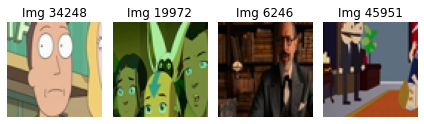

img     7967	 shape torch.Size([3, 64, 64])   	 type photo
img     6145	 shape torch.Size([3, 64, 64])   	 type photo
img     7938	 shape torch.Size([3, 64, 64])   	 type photo
img     7823	 shape torch.Size([3, 64, 64])   	 type photo


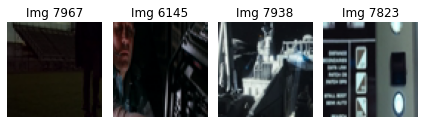

img    51091	 shape torch.Size([3, 64, 64])   	 type anime
img    48617	 shape torch.Size([3, 64, 64])   	 type anime
img    48649	 shape torch.Size([3, 64, 64])   	 type photo
img    45822	 shape torch.Size([3, 64, 64])   	 type photo


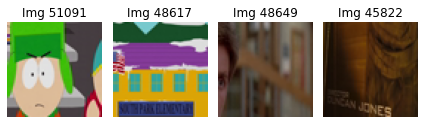

img     6408	 shape torch.Size([3, 64, 64])   	 type photo
img     4094	 shape torch.Size([3, 64, 64])   	 type photo
img     4009	 shape torch.Size([3, 64, 64])   	 type photo
img     6940	 shape torch.Size([3, 64, 64])   	 type anime


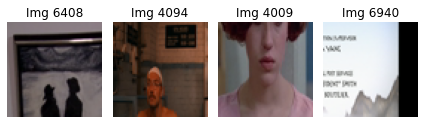

img    17571	 shape torch.Size([3, 64, 64])   	 type photo
img     7166	 shape torch.Size([3, 64, 64])   	 type photo
img     9701	 shape torch.Size([3, 64, 64])   	 type anime
img    41842	 shape torch.Size([3, 64, 64])   	 type anime


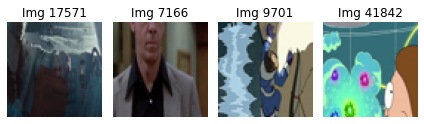

img     8504	 shape torch.Size([3, 64, 64])   	 type photo
img      808	 shape torch.Size([3, 64, 64])   	 type photo
img    13713	 shape torch.Size([3, 64, 64])   	 type photo
img     3394	 shape torch.Size([3, 64, 64])   	 type photo


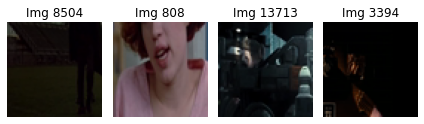

In [5]:
def showRandom(d):
    fig = plt.figure()
    for i, imgidx in enumerate(np.random.randint(0, len(d), 4)):
        image, label = d[imgidx]
        print(f'img {imgidx:8d}\t', f'shape {str(image.shape):26s}\t',
              'type', 'anime' if label == 1 else 'photo')

        ax = plt.subplot(1, 4, i + 1)
        ax.imshow(transform_backward(image))
        ax.set_title(f'Img {imgidx}')
        ax.axis('off')

        plt.tight_layout()

    plt.show()


for _ in range(4):
    showRandom(dataset_train)
    showRandom(dataset_test)


In [6]:
print(f'Training N photo: {np.sum(dataset_train.labels.numpy() == 0):8d}')
print(f'Training N anime: {np.sum(dataset_train.labels.numpy() == 1):8d}')


Training N photo:    30000
Training N anime:    30000


In [7]:
class IsAnime(torch.nn.Module):
    def __init__(self):
        super(IsAnime, self).__init__()

        self.epoch = 0

        self.kernel = 9

        self.conv1 = torch.nn.Conv2d(3, 6, self.kernel)
        self.conv2 = torch.nn.Conv2d(6, 16, self.kernel)
        self.fc1 = torch.nn.Linear(1600, 1024)
        self.fc2 = torch.nn.Linear(1024, 256)
        self.fc3 = torch.nn.Linear(256, 64)
        self.fc4 = torch.nn.Linear(64, 1)
        
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.pool = torch.nn.MaxPool2d(2)
        self.sigmoidsharp = lambda x: torch.nn.ReLU6()(x * 6) / 6

    def forward(self, x):
        
        x.float()
        
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = torch.squeeze(x)

        x.float()
        
        return self.sigmoidsharp(x)


import torch.nn as nn
import torch.nn.functional as F
class IsAnimeAlternate(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 12, 5)
        self.fc1 = nn.Linear(2028, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

        self.epoch = 0

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.squeeze(F.relu6(x * 6) / 6)


class ReallySimpleClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.epoch = 0
        self.lr = 1e-4

        self.activation = torch.nn.Sigmoid()
        self.pool = torch.nn.MaxPool2d(2)

        self.conv1 = torch.nn.Conv2d(3, 9, 5)
        self.fc1 = torch.nn.Linear(8100, 1)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = torch.squeeze(x)
        return x


net = ReallySimpleClassifier().cuda()
net.float()  # to be extra sure

print(net)


ReallySimpleClassifier(
  (activation): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=8100, out_features=1, bias=True)
)


In [8]:
import torchsummary
torchsummary.summary(net, (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 60, 60]             684
           Sigmoid-2            [-1, 9, 60, 60]               0
         MaxPool2d-3            [-1, 9, 30, 30]               0
            Linear-4                    [-1, 1]           8,101
           Sigmoid-5                    [-1, 1]               0
Total params: 8,785
Trainable params: 8,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.56
Params size (MB): 0.03
Estimated Total Size (MB): 0.64
----------------------------------------------------------------


In [9]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=net.lr, momentum=0.9)


In [10]:
batch_size = int(1024)

# technically I already shuffled, but it probably doesn't matter, right?
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


In [11]:
print('Training...')

epsilon_train = 0.0001  # smaller than <epsilon_train> change in ratios of loss values

loss_last = 1000000000.
loss_this = 100000000.  # some number bigger than any possible loss
while loss_last / loss_this > 1 + epsilon_train:
    loss_last = loss_this
    loss_this = 0.
    net.epoch += 1

    for i, data in enumerate(loader_train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].cuda(), data[1].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()            
        optimizer.step()

        # print statistics
        loss_this += loss.item()
        # print(f'\tBatch {i:02d} loss: {loss.item():.2f}')
    print(f'Epoch {net.epoch:02d} loss: {loss_this:.3f}')


print('Finished training.')


Training...
Epoch 01 loss: 40.065
Epoch 02 loss: 37.534
Epoch 03 loss: 35.159
Epoch 04 loss: 33.011
Epoch 05 loss: 31.505
Epoch 06 loss: 30.660
Epoch 07 loss: 30.256
Epoch 08 loss: 30.000
Epoch 09 loss: 29.866
Epoch 10 loss: 29.834
Epoch 11 loss: 29.745
Epoch 12 loss: 29.662
Epoch 13 loss: 29.624
Epoch 14 loss: 29.630
Finished training.


In [12]:
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(loader_test):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        
        outputs = net(images)
        predictions = [1. if f >= 0.5 else 0. for f in outputs]
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct += 1
            total += 1
            
        if i > 10:
            break


# print accuracy for each class
print('correct', correct)
print('total', total)


correct 9582
total 12288


In [13]:
print(f'{correct / total * 100:03.1f}%')


77.9%


In [14]:
torch.save(net.state_dict(), os.path.join('model', f'{net._get_name()}_{datetime.datetime.now().strftime("%Y%m%dT%H%M")}.pth'))
